In [1]:
# Mount Google Drive and set data directory
from google.colab import drive
from pathlib import Path

drive.mount("/content/drive")

DRIVE_DATA_DIR = Path("/content/drive/MyDrive/kaggle_data/fer-plus-dataset")
print(f"📂 Data directory: {DRIVE_DATA_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Data directory: /content/drive/MyDrive/kaggle_data/fer-plus-dataset


In [2]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install torch
! pip install torchvision
! pip install torchmetrics
! pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics

from torchvision import models
from PIL import Image

import time

In [4]:
class FERPlusDataset(Dataset):
    """
    Load FER2013 images with FER+ corrected labels.

    Combines:
    - fer2013.csv (original pixel data)
    - fer2013new.csv (FER+ corrected labels with vote counts)

    Filters out ambiguous images with < min_votes total votes.
    """

    def __init__(self, fer2013_csv, ferplus_csv, usage='Training', transform=None, min_votes=5):
        """
        Args:
            fer2013_csv: Path to fer2013.csv
            ferplus_csv: Path to fer2013new.csv
            usage: 'Training', 'PublicTest', or 'PrivateTest'
            transform: PyTorch transforms
            min_votes: Min total votes to include sample (filters ambiguous images)
        """
        print(f"📂 Loading {usage} data...")

        # Load FER2013 (has pixels)
        fer2013_df = pd.read_csv(fer2013_csv)
        fer2013_df = fer2013_df[fer2013_df['Usage'] == usage].reset_index(drop=True)

        # Load FER+ (corrected labels)
        ferplus_df = pd.read_csv(ferplus_csv)
        ferplus_df = ferplus_df[ferplus_df['Usage'] == usage].reset_index(drop=True)

        print(f"   FER2013: {len(fer2013_df)} images")
        print(f"   FER+: {len(ferplus_df)} labels")

        # Combine: FER2013 pixels + FER+ corrected labels
        self.images = []
        self.labels = []

        for idx in range(min(len(fer2013_df), len(ferplus_df))):
            # Get pixels from FER2013
            pixels_str = fer2013_df.iloc[idx]['pixels']
            pixels = np.array([int(p) for p in pixels_str.split()], dtype=np.uint8)
            pixels = pixels.reshape(48, 48)

            # Get FER+ corrected label (majority vote from 10 annotators)
            ferplus_row = ferplus_df.iloc[idx]
            # CRITICAL: Match FER2013 emotion order!
            # FER2013 classes: 0=angry, 1=disgust, 2=fear, 3=happy, 4=neutral, 5=sad, 6=surprise
            votes = [
                ferplus_row['anger'],       # 0 - angry
                ferplus_row['disgust'],     # 1 - disgust
                ferplus_row['fear'],        # 2 - fear
                ferplus_row['happiness'],   # 3 - happy
                ferplus_row['neutral'],     # 4 - neutral
                ferplus_row['sadness'],     # 5 - sad
                ferplus_row['surprise']     # 6 - surprise
                # Skip 'contempt' (not in FER2013)
            ]

            # Filter low-confidence samples
            total_votes = sum(votes)
            if total_votes < min_votes:
                continue  # Skip ambiguous images

            # Get majority vote emotion
            emotion = np.argmax(votes)

            self.images.append(pixels)
            self.labels.append(emotion)

        self.images = np.array(self.images)
        self.labels = np.array(self.labels)
        self.transform = transform

        filtered = min(len(fer2013_df), len(ferplus_df)) - len(self.images)
        print(f"   ✅ Loaded {len(self.images)} images")
        print(f"   🗑️  Filtered {filtered} ambiguous samples (< {min_votes} votes)")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image and label
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL for transforms
        image = Image.fromarray(image, mode='L')  # L = grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Enable cuDNN optimizations
    torch.backends.cudnn.benchmark = True

    # AMP setup
    use_amp = True
    scaler = torch.amp.GradScaler('cuda')
else:
    print("⚠️  WARNING: No GPU! Go to Runtime -> Change runtime type -> T4 GPU")
    use_amp = False
    scaler = None

Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [6]:
batch_size = 128

# Định nghĩa cho tập TRAIN (Có Augmentation)
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),

    # Agument data
    transforms.RandomHorizontalFlip(p=0.5), # 50% cơ hội lật ảnh
    transforms.RandomRotation(10),           # Xoay tối đa 10 độ
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Dịch chuyển ảnh nhẹ

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.3),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    transforms.RandomAutocontrast(p=0.3),

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Định nghĩa cho tập TEST (Khong co Augmentation)
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load from CSV with corrected labels
fer2013_csv = f"{DRIVE_DATA_DIR}/fer2013.csv"
ferplus_csv = f"{DRIVE_DATA_DIR}/fer2013new.csv"

train_dataset = FERPlusDataset(
    fer2013_csv=fer2013_csv,
    ferplus_csv=ferplus_csv,
    usage='Training',
    transform=transform_train,
    min_votes=5  # Filter ambiguous samples
)

test_dataset = FERPlusDataset(
    fer2013_csv=fer2013_csv,
    ferplus_csv=ferplus_csv,
    usage='PublicTest',  # Validation set
    transform=transform_test,
    min_votes=5
)

pin_memory = False
if device == "cuda":
    pin_memory = True

train_loader = DataLoader(
    batch_size=batch_size,
    dataset=train_dataset,
    shuffle=True,
    num_workers=2,  # Colab works best with 2
    pin_memory=pin_memory,
    persistent_workers=True,
    prefetch_factor=2,  # Preload batches
)
test_loader = DataLoader(
    batch_size=batch_size,
    dataset=test_dataset,
    shuffle=False,
    num_workers=2,
    pin_memory=pin_memory,
    persistent_workers=True,
)

print(f"\n{'='*60}")
print(f"📊 Dataset Summary (FER+ Corrected Labels)")
print(f"{'='*60}")
print(f"Train: {len(train_dataset)} images, {len(train_loader)} batches")
print(f"Test:  {len(test_dataset)} images, {len(test_loader)} batches")
print(f"{'='*60}")

📂 Loading Training data...
   FER2013: 28709 images
   FER+: 28709 labels
   ✅ Loaded 28409 images
   🗑️  Filtered 300 ambiguous samples (< 5 votes)
📂 Loading PublicTest data...
   FER2013: 3589 images
   FER+: 3589 labels
   ✅ Loaded 3558 images
   🗑️  Filtered 31 ambiguous samples (< 5 votes)

📊 Dataset Summary (FER+ Corrected Labels)
Train: 28409 images, 222 batches
Test:  3558 images, 28 batches


In [7]:
all_labels = train_dataset.labels  # FERPlusDataset uses .labels (not .targets)
unique_labels, counts = np.unique(all_labels, return_counts=True)

total_samples = len(train_dataset)
num_classes = len(unique_labels)

weights = [total_samples / (num_classes * c) for c in counts]
class_weights = torch.FloatTensor(weights).to(device)

print(f"\n{'='*60}")
print(f"📊 Class Distribution (FER+ Corrected)")
print(f"{'='*60}")
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
for i, (cat, count, weight) in enumerate(zip(categories, counts, weights)):
    print(f"{cat:8s}: {count:5d} ({count/total_samples*100:5.1f}%) | weight: {weight:.3f}")
print(f"{'='*60}")
print(f"Total: {total_samples} samples")
print(f"Weights: {weights}")


📊 Class Distribution (FER+ Corrected)
angry   :  2757 (  9.7%) | weight: 1.472
disgust :   248 (  0.9%) | weight: 16.365
fear    :   817 (  2.9%) | weight: 4.967
happy   :  7623 ( 26.8%) | weight: 0.532
neutral : 10071 ( 35.5%) | weight: 0.403
sad     :  3490 ( 12.3%) | weight: 1.163
surprise:  3403 ( 12.0%) | weight: 1.193
Total: 28409 samples
Weights: [np.float64(1.472045183688274), np.float64(16.36463133640553), np.float64(4.967476831613919), np.float64(0.5323925713536103), np.float64(0.4029816871639928), np.float64(1.1628735161686452), np.float64(1.1926031652743379)]


In [9]:
x, y = train_dataset[0]
print(x.shape)

/tmp/ipython-input-2749948138.py:85: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode='L')  # L = grayscale


torch.Size([1, 48, 48])


/tmp/ipython-input-2749948138.py:85: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode='L')  # L = grayscale
/tmp/ipython-input-2749948138.py:85: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode='L')  # L = grayscale


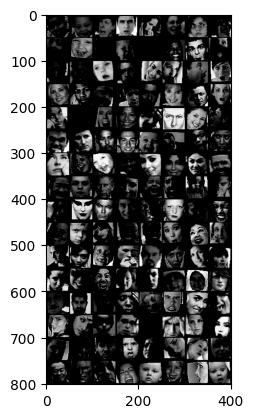

In [10]:
def img_show(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# get some random image
data_iter = iter(train_loader)
images, labels = next(data_iter)

labels

img_show(torchvision.utils.make_grid(images))

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        """
        Building blocks of convolutional neural network.
        Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 7 (i.e 7 emotions).
        """
        super(CNN, self).__init__()

        # Các lớp trích xuất đặc trưng (Feature Extraction)
        """
        Conv2d: Nhìn và tìm đặc trưng.

        BatchNorm2d: Chuẩn hóa dữ liệu cho lớp sau dễ học.

        ReLU: Loại bỏ các giá trị âm (không quan trọng).

        MaxPool2d: Tóm tắt lại những gì vừa nhìn thấy.

        Dropout: Ép mô hình học kĩ, không học vẹt.
        """

        self.features = nn.Sequential(
            # Block 1: 48x48 -> 24x24
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2nd convolution layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3nd convolution layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 4nd convolution layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((1,1)) # Gom về 256 con số
        )

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: Input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = self.features(x) # Output: (Batch, 16, 1, 1)
        x = torch.flatten(x, 1) # Biến thành vector: (Batch, 16)
        x = self.fc(x) # Dự đoán: (Batch, 10)

        return x

In [8]:
class SEBlock(nn.Module):
    """Channel attention - helps model focus on important features"""
    def __init__(self, channels, reduction=32):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResBlockSE(nn.Module):
    """ResBlock with SE attention"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)  # ADD SE ATTENTION

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)  # Apply attention
        out += self.shortcut(x)
        return F.relu(out)

In [9]:
class FocalLoss(nn.Module):
    """Handles class imbalance better than CrossEntropy"""
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha  # class weights
        self.gamma = gamma
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(
            inputs, targets,
            weight=self.alpha,
            reduction='none',
            label_smoothing=self.label_smoothing
        )
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [10]:
class ResBlock(nn.Module):
    """
    Basic residual block with two conv layers and skip connection.

    Structure:
        x -> Conv -> BN -> ReLU -> Conv -> BN -> + -> ReLU -> out
        |_______________________________________|
                    (skip connection)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        # Lop Conv 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Lop Conv 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)


        # Đường tắt (Skip Connection)
        # Nếu số kênh thay đổi hoặc stride > 1, ta cần dùng Conv 1x1 để khớp kích thước
        self.shortcut = nn.Identity() # Changed from nn.Sequential() to nn.Identity() for robustness
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Cộng tín hiệu cũ (identity) vào kết quả mới
        out += self.shortcut(identity)
        out = F.relu(out)

        return out

In [11]:
class ResNet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        # Stem with more channels
        self.stem = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),  # Extra conv
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # ResBlocks with SE attention
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Better classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self._init_weights()

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = [ResBlockSE(in_ch, out_ch, stride)]
        for _ in range(1, blocks):
            layers.append(ResBlockSE(out_ch, out_ch))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
# model = CNN(in_channels=1, num_classes=7).to(device)
# model_path = f"{DRIVE_DATA_DIR}/emotion_model.pth"

model = ResNet(num_classes=7).to(device)
model_path = f"{DRIVE_DATA_DIR}/emotion_resnet_fer_model.pth"

# model = EfficientNetEmotion(num_classes=7, pretrained=True).to(device)
# model_path = f"{DRIVE_DATA_DIR}/emotion_efficientnet.pth"

In [13]:
# define loss function
# loss = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
loss = FocalLoss(alpha=class_weights, gamma=2.0, label_smoothing=0.1)

# define optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)

# Nếu Val Accuracy không tăng sau 5 epoch, giảm LR đi một nửa -> chọn accuracy cang lon con tot
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6)

from torch.optim.lr_scheduler import OneCycleLR
num_epochs = 25  # OneCycleLR converges faster, 25 is enough

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=num_epochs,  # Use variable, not hardcoded
    steps_per_epoch=len(train_loader),
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos'
)

In [14]:
best_accuracy = 0.0
start_epoch = 0

# Resume from checkpoint if exists (handles Colab disconnects)
checkpoint_path = f"{DRIVE_DATA_DIR}/checkpoint_resnet_fer.pth"

if Path(checkpoint_path).exists():
    print("📂 Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_epoch = checkpoint['epoch'] + 1
    best_accuracy = checkpoint['best_accuracy']
    if use_amp and 'scaler' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler'])
    print(f"✅ Resumed from epoch {start_epoch}, best acc: {best_accuracy:.2f}%")

for epoch in range(start_epoch, num_epochs):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(train_loader, leave=True)

    for data, targets in loop:
        data = data.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.amp.autocast('cuda'):
                scores = model(data)
                loss_value = loss(scores, targets)
            scaler.scale(loss_value).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            scores = model(data)
            loss_value = loss(scores, targets)
            loss_value.backward()
            optimizer.step()

        scheduler.step()  # OneCycleLR: step per BATCH, not per epoch!

        running_loss += loss_value.item()
        _, predictions = scores.max(1)
        correct_train += (predictions == targets).sum().item()
        total_train += targets.size(0)

        loop.set_description(f"Loss: {loss_value.item():.4f}")

    train_acc = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)

    # --- EVALUATION ---
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            if use_amp:
                with torch.amp.autocast('cuda'):
                    scores = model(data)
                    v_loss = loss(scores, targets)
            else:
                scores = model(data)
                v_loss = loss(scores, targets)

            val_loss += v_loss.item()
            _, predictions = scores.max(1)
            correct_val += (predictions == targets).sum().item()
            total_val += targets.size(0)

    val_acc = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(test_loader)

    current_lr = optimizer.param_groups[0]['lr']
    epoch_time = time.time() - epoch_start

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}   | Val Acc: {val_acc:.2f}% | LR: {current_lr:.6f}")
    print(f"⏱️  Epoch time: {epoch_time:.1f}s")

    # Save checkpoint every epoch (to Google Drive - survives disconnect)
    checkpoint = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'best_accuracy': best_accuracy,
    }
    if use_amp:
        checkpoint['scaler'] = scaler.state_dict()
    torch.save(checkpoint, checkpoint_path)

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"🏆 Saved best model: {val_acc:.2f}%")

print(f"\n✅ Training complete! Best accuracy: {best_accuracy:.2f}%")


Epoch 1/25


  0%|          | 0/222 [00:00<?, ?it/s]/tmp/ipython-input-1284905320.py:87: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode='L')  # L = grayscale
/tmp/ipython-input-1284905320.py:87: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode='L')  # L = grayscale
Loss: 1.8774: 100%|██████████| 222/222 [00:49<00:00,  4.45it/s]
/tmp/ipython-input-1284905320.py:87: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode='L')  # L = grayscale
/tmp/ipython-input-1284905320.py:87: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image, mode='L')  # L = grayscale


Train Loss: 1.9144 | Train Acc: 2.22%
Val Loss: 1.8864   | Val Acc: 2.64% | LR: 0.000373
⏱️  Epoch time: 51.2s
🏆 Saved best model: 2.64%

Epoch 2/25


Loss: 1.3070: 100%|██████████| 222/222 [00:28<00:00,  7.69it/s]


Train Loss: 1.7559 | Train Acc: 9.08%
Val Loss: 3.0849   | Val Acc: 20.74% | LR: 0.000910
⏱️  Epoch time: 29.9s
🏆 Saved best model: 20.74%

Epoch 3/25


Loss: 1.4430: 100%|██████████| 222/222 [00:28<00:00,  7.79it/s]


Train Loss: 1.5513 | Train Acc: 27.06%
Val Loss: 1.6765   | Val Acc: 37.89% | LR: 0.000999
⏱️  Epoch time: 29.8s
🏆 Saved best model: 37.89%

Epoch 4/25


Loss: 1.4755: 100%|██████████| 222/222 [00:28<00:00,  7.68it/s]


Train Loss: 1.4312 | Train Acc: 36.88%
Val Loss: 1.4003   | Val Acc: 38.84% | LR: 0.000989
⏱️  Epoch time: 30.0s
🏆 Saved best model: 38.84%

Epoch 5/25


Loss: 1.1662: 100%|██████████| 222/222 [00:29<00:00,  7.56it/s]


Train Loss: 1.3473 | Train Acc: 43.42%
Val Loss: 1.3712   | Val Acc: 47.22% | LR: 0.000970
⏱️  Epoch time: 30.7s
🏆 Saved best model: 47.22%

Epoch 6/25


Loss: 1.3219: 100%|██████████| 222/222 [00:28<00:00,  7.68it/s]


Train Loss: 1.2861 | Train Acc: 48.25%
Val Loss: 1.3051   | Val Acc: 43.03% | LR: 0.000941
⏱️  Epoch time: 30.3s

Epoch 7/25


Loss: 1.3647: 100%|██████████| 222/222 [00:29<00:00,  7.52it/s]


Train Loss: 1.2444 | Train Acc: 51.04%
Val Loss: 1.3044   | Val Acc: 60.74% | LR: 0.000904
⏱️  Epoch time: 30.6s
🏆 Saved best model: 60.74%

Epoch 8/25


Loss: 1.1873: 100%|██████████| 222/222 [00:28<00:00,  7.75it/s]


Train Loss: 1.1918 | Train Acc: 54.22%
Val Loss: 1.1679   | Val Acc: 50.62% | LR: 0.000859
⏱️  Epoch time: 29.7s

Epoch 9/25


Loss: 1.1465: 100%|██████████| 222/222 [00:29<00:00,  7.58it/s]


Train Loss: 1.1714 | Train Acc: 55.97%
Val Loss: 1.2744   | Val Acc: 38.87% | LR: 0.000808
⏱️  Epoch time: 30.3s

Epoch 10/25


Loss: 0.8991: 100%|██████████| 222/222 [00:28<00:00,  7.75it/s]


Train Loss: 1.1389 | Train Acc: 57.70%
Val Loss: 1.1353   | Val Acc: 68.61% | LR: 0.000750
⏱️  Epoch time: 29.7s
🏆 Saved best model: 68.61%

Epoch 11/25


Loss: 0.8963: 100%|██████████| 222/222 [00:28<00:00,  7.75it/s]


Train Loss: 1.1024 | Train Acc: 61.30%
Val Loss: 1.1037   | Val Acc: 55.79% | LR: 0.000687
⏱️  Epoch time: 29.7s

Epoch 12/25


Loss: 1.0803: 100%|██████████| 222/222 [00:29<00:00,  7.44it/s]


Train Loss: 1.0737 | Train Acc: 61.83%
Val Loss: 1.0844   | Val Acc: 66.19% | LR: 0.000621
⏱️  Epoch time: 31.1s

Epoch 13/25


Loss: 0.9268: 100%|██████████| 222/222 [00:29<00:00,  7.62it/s]


Train Loss: 1.0431 | Train Acc: 64.11%
Val Loss: 1.1158   | Val Acc: 64.00% | LR: 0.000552
⏱️  Epoch time: 30.5s

Epoch 14/25


Loss: 0.9160: 100%|██████████| 222/222 [00:28<00:00,  7.69it/s]


Train Loss: 1.0145 | Train Acc: 66.10%
Val Loss: 1.1083   | Val Acc: 64.95% | LR: 0.000482
⏱️  Epoch time: 29.9s

Epoch 15/25


Loss: 0.9054: 100%|██████████| 222/222 [00:28<00:00,  7.70it/s]


Train Loss: 0.9992 | Train Acc: 66.95%
Val Loss: 1.0518   | Val Acc: 70.94% | LR: 0.000413
⏱️  Epoch time: 29.9s
🏆 Saved best model: 70.94%

Epoch 16/25


Loss: 1.0324: 100%|██████████| 222/222 [00:28<00:00,  7.77it/s]


Train Loss: 0.9729 | Train Acc: 69.41%
Val Loss: 1.0297   | Val Acc: 72.32% | LR: 0.000345
⏱️  Epoch time: 29.7s
🏆 Saved best model: 72.32%

Epoch 17/25


Loss: 0.9781: 100%|██████████| 222/222 [00:29<00:00,  7.54it/s]


Train Loss: 0.9541 | Train Acc: 70.01%
Val Loss: 1.0504   | Val Acc: 67.54% | LR: 0.000281
⏱️  Epoch time: 30.5s

Epoch 18/25


Loss: 1.2526: 100%|██████████| 222/222 [00:29<00:00,  7.53it/s]


Train Loss: 0.9273 | Train Acc: 71.79%
Val Loss: 1.0208   | Val Acc: 71.87% | LR: 0.000220
⏱️  Epoch time: 30.5s

Epoch 19/25


Loss: 0.9097: 100%|██████████| 222/222 [00:29<00:00,  7.56it/s]


Train Loss: 0.8973 | Train Acc: 73.67%
Val Loss: 0.9979   | Val Acc: 70.77% | LR: 0.000165
⏱️  Epoch time: 30.8s

Epoch 20/25


Loss: 0.8517: 100%|██████████| 222/222 [00:29<00:00,  7.62it/s]


Train Loss: 0.8778 | Train Acc: 74.73%
Val Loss: 0.9844   | Val Acc: 74.76% | LR: 0.000117
⏱️  Epoch time: 30.6s
🏆 Saved best model: 74.76%

Epoch 21/25


Loss: 0.7341: 100%|██████████| 222/222 [00:29<00:00,  7.64it/s]


Train Loss: 0.8686 | Train Acc: 75.15%
Val Loss: 0.9913   | Val Acc: 76.11% | LR: 0.000076
⏱️  Epoch time: 30.2s
🏆 Saved best model: 76.11%

Epoch 22/25


Loss: 0.8408: 100%|██████████| 222/222 [00:29<00:00,  7.59it/s]


Train Loss: 0.8490 | Train Acc: 76.09%
Val Loss: 0.9817   | Val Acc: 75.41% | LR: 0.000043
⏱️  Epoch time: 30.3s

Epoch 23/25


Loss: 0.9504: 100%|██████████| 222/222 [00:28<00:00,  7.75it/s]


Train Loss: 0.8378 | Train Acc: 75.93%
Val Loss: 0.9764   | Val Acc: 76.76% | LR: 0.000019
⏱️  Epoch time: 29.7s
🏆 Saved best model: 76.76%

Epoch 24/25


Loss: 0.9203: 100%|██████████| 222/222 [00:29<00:00,  7.65it/s]


Train Loss: 0.8366 | Train Acc: 76.72%
Val Loss: 0.9778   | Val Acc: 76.48% | LR: 0.000005
⏱️  Epoch time: 30.1s

Epoch 25/25


Loss: 0.7079: 100%|██████████| 222/222 [00:30<00:00,  7.39it/s]


Train Loss: 0.8261 | Train Acc: 76.95%
Val Loss: 0.9763   | Val Acc: 76.08% | LR: 0.000000
⏱️  Epoch time: 31.3s

✅ Training complete! Best accuracy: 76.76%


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# model = CNN(in_channels=1, num_classes=7).to(device)

model = ResNet(num_classes=7).to(device)

# Load the entire checkpoint dictionary
checkpoint = torch.load(checkpoint_path)
# Extract the model's state_dict from the checkpoint
model.load_state_dict(checkpoint['model'])

model.eval()
all_preds = []
all_labels = []

categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs, 1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("--- EVALUATION REPORT ---")
print(classification_report(all_labels, all_preds, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
print(df_cm)

--- EVALUATION REPORT ---
              precision    recall  f1-score   support

       angry       0.73      0.80      0.76       345
     disgust       0.15      0.64      0.24        45
        fear       0.48      0.72      0.58        94
       happy       0.92      0.90      0.91       903
     neutral       0.90      0.63      0.74      1320
         sad       0.53      0.78      0.63       405
    surprise       0.84      0.84      0.84       446

    accuracy                           0.76      3558
   macro avg       0.65      0.76      0.67      3558
weighted avg       0.82      0.76      0.78      3558

          angry  disgust  fear  happy  neutral  sad  surprise
angry       275       25     9      2       15   12         7
disgust       8       29     1      2        1    4         0
fear          6        3    68      3        3    3         8
happy        13       17     1    812       26   18        16
neutral      45      101    19     52      834  235        34
sad  

In [ ]:
# export model to TorchScript

model_path_ts = f"{DRIVE_DATA_DIR}/emotion_model_ts.pth"

# Instantiate the model with the correct architecture
model = CNN(in_channels=1, num_classes=7)
# Load the state dictionary into the model
model.load_state_dict(torch.load(model_path, map_location="cpu"))

model.eval()

example = torch.randn(1, 1, 48, 48)  # chỉnh đúng input
ts = torch.jit.trace(model, example)
ts = torch.jit.freeze(ts)
ts.save(model_path_ts)

In [17]:
# export model to TorchScript

checkpoint_path = f"{DRIVE_DATA_DIR}/checkpoint_resnet_fer.pth"

model_resnet_path_ts = f"{DRIVE_DATA_DIR}/emotion_resnet_fer_model_ts.pth"

# Instantiate the model with the correct architecture
model = ResNet(num_classes=7)

# Load the entire checkpoint dictionary
checkpoint = torch.load(checkpoint_path)
# Extract the model's state_dict from the checkpoint
model.load_state_dict(checkpoint['model'])

model.eval()

example = torch.randn(1, 1, 48, 48)  # chỉnh đúng input
ts = torch.jit.trace(model, example)
ts = torch.jit.freeze(ts)
ts.save(model_resnet_path_ts)